In [18]:
import numpy as np
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from models.CNN import create_cnn_model

In [9]:
def load(f):
    # Move up one directory when loading the data
    file_path = os.path.join('../../../', f)
    return np.load(file_path)['arr_0']

# Load the data
x_train = load('kmnist-train-imgs.npz')/ 255.0
x_test = load('kmnist-test-imgs.npz')/ 255.0
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')
# Reshape the data for CNN input
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [10]:
# Define the input shape and number of classes
input_shape = x_train.shape[1:]  # 784 for KMNIST
num_classes = y_train.max() + 1

In [25]:
# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # Randomly shift images vertically (fraction of total height)
    zoom_range=0.1,  # Randomly zoom image
)


In [26]:
hyperparameters = {
    'num_layers': 3,
    'filters': [32, 64, 64],
    'kernel_sizes': [(3, 3), (3, 3), (3, 3)],
    'activations': ['relu', 'relu', 'relu'],
    'dense_units': 64,
    'dense_activation': 'relu'
}
configs = [
    {'batch_normalization': False, 'pooling': 'max', 'datagen': True},
    {'batch_normalization': True, 'pooling': 'max', 'datagen': True},
    {'batch_normalization': False, 'pooling': 'avg', 'datagen': True},
    {'batch_normalization': True, 'pooling': 'avg', 'datagen': True},
    {'batch_normalization': False, 'pooling': 'max', 'datagen': False},
    {'batch_normalization': True, 'pooling': 'max', 'datagen': False},
    {'batch_normalization': False, 'pooling': 'avg', 'datagen': False},
    {'batch_normalization': True, 'pooling': 'avg', 'datagen': False}
]

best_config = None
best_accuracy = 0
histories = []
for config in configs:
    print(f"Testing configuration: {config}")
    hyperparameters.update(config)
    model = create_cnn_model(input_shape, num_classes, hyperparameters)
    if config['datagen']:
        history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                            epochs=10,
                            validation_data=(x_test, y_test),
                            verbose=1)
    else:
        history = model.fit(x_train, y_train,
                            epochs=10,
                            batch_size=32,
                            validation_split=0.1,
                            verbose=1)
    histories.append(history)
    final_acc = history.history['val_accuracy'][-1]
    if final_acc > best_accuracy:
        best_accuracy = final_acc
        best_config = config
print(f"Best configuration: {best_config}")
print(f"Best accuracy: {best_accuracy}")
# Train the best model on the full training set and evaluate on test set
print("Training best model on full training set...")
hyperparameters = hyperparameters.copy()
hyperparameters.update(best_config)

# Create and compile the best model
best_model = create_cnn_model(input_shape, num_classes, hyperparameters)

# Train on the full training set
if best_config['datagen']:
    history = best_model.fit(datagen.flow(x_train, y_train, batch_size=32),
                            epochs=20,
                            validation_split=0.1,
                            verbose=1)
else:
    history = best_model.fit(x_train, y_train, 
                             epochs=20, 
                             batch_size=32, 
                             validation_split=0.1, 
                             verbose=1)

# Evaluate on the test set
test_loss, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")



Testing configuration: {'batch_normalization': False, 'pooling': 'max', 'datagen': True}
Epoch 1/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.7079 - accuracy: 0.7683 - val_loss: 0.6037 - val_accuracy: 0.8184
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3379 - accuracy: 0.8929 - val_loss: 0.4694 - val_accuracy: 0.8582
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2566 - accuracy: 0.9187 - val_loss: 0.4327 - val_accuracy: 0.8744
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2136 - accuracy: 0.9312 - val_loss: 0.3877 - val_accuracy: 0.8922
Epoch 5/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1914 - accuracy: 0.9396 - val_loss: 0.3491 - val_accuracy: 0.9040
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1725 - accuracy: 0.9465 - val_loss: 0.2866 - val_accuracy: 0.9201
Epoch 7/10
1875/1875 [===================

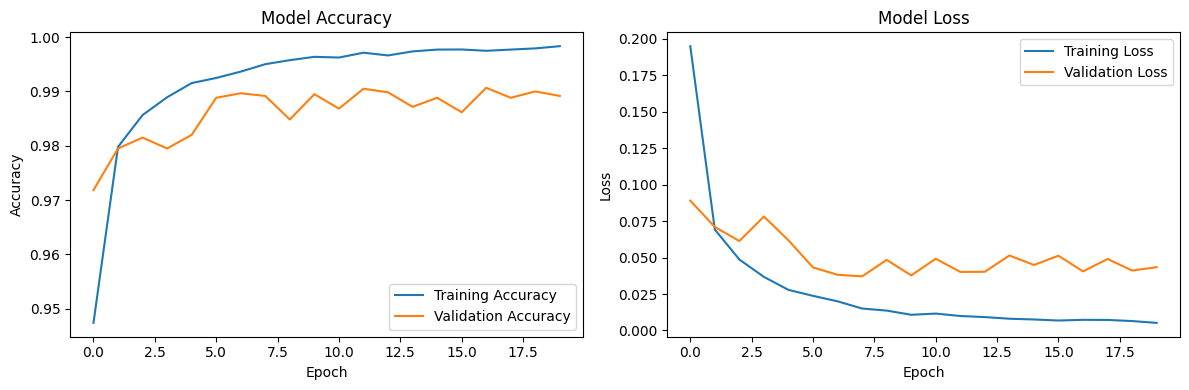

In [27]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()